In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.AnomalyDetector import AnomalyDetector
from utils.Advanced_LSTM import AdvancedLSTM

import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from torch.nn.modules import LSTM
from torch.optim import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Data exploration
The dataset represent a multivariate time series of different space missions. The dataset contains different feature that can be splitted into three main groups:
* target channels that are the one used to detect the anomaly events
* non target channels
* telecommand execution done during mission
The target channels are provided beforehead so it's possible to split the dataset.

In [2]:
train_df = pd.read_parquet(r'data\train.parquet')
target_columns = pd.read_csv(r'data\target_channels.csv')['target_channels'].tolist()

As it can be saw there are no missing value on the collected data (due to preprocess done by the competition hosts).

In [3]:
train_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14728321 entries, 0 to 14728320
Data columns (total 89 columns):
 #   Column           Non-Null Count     Dtype  
---  ------           --------------     -----  
 0   id               14728321 non-null  int64  
 1   channel_1        14728321 non-null  float32
 2   channel_10       14728321 non-null  float32
 3   channel_11       14728321 non-null  float32
 4   channel_12       14728321 non-null  float32
 5   channel_13       14728321 non-null  float32
 6   channel_14       14728321 non-null  float32
 7   channel_15       14728321 non-null  float32
 8   channel_16       14728321 non-null  float32
 9   channel_17       14728321 non-null  float32
 10  channel_18       14728321 non-null  float32
 11  channel_19       14728321 non-null  float32
 12  channel_2        14728321 non-null  float32
 13  channel_20       14728321 non-null  float32
 14  channel_21       14728321 non-null  float32
 15  channel_22       14728321 non-null  float32
 16

Next the split of the dataset's features can be done by using the target data and the name of the feature.

In [4]:
columns = train_df.columns.to_list()
telecommands_columns = train_df.filter(regex='telecommand').columns.to_list()
non_target_columns = [x for x in columns if x not in target_columns and x not in telecommands_columns]
non_target_columns.remove('is_anomaly')

Done that the correlation amongst the channels can be checked by combining the target and non target channel.

In [5]:
channels = target_columns + non_target_columns
X_train = train_df[channels]
y_train = train_df['is_anomaly']

From the correlattion matrix it can be saw that it' possible to split the channel into group with high positive correlations. \
This could be a result of the fact that those channel registers similar information, but this can only be an assumption due to the anonimizzation of the features.

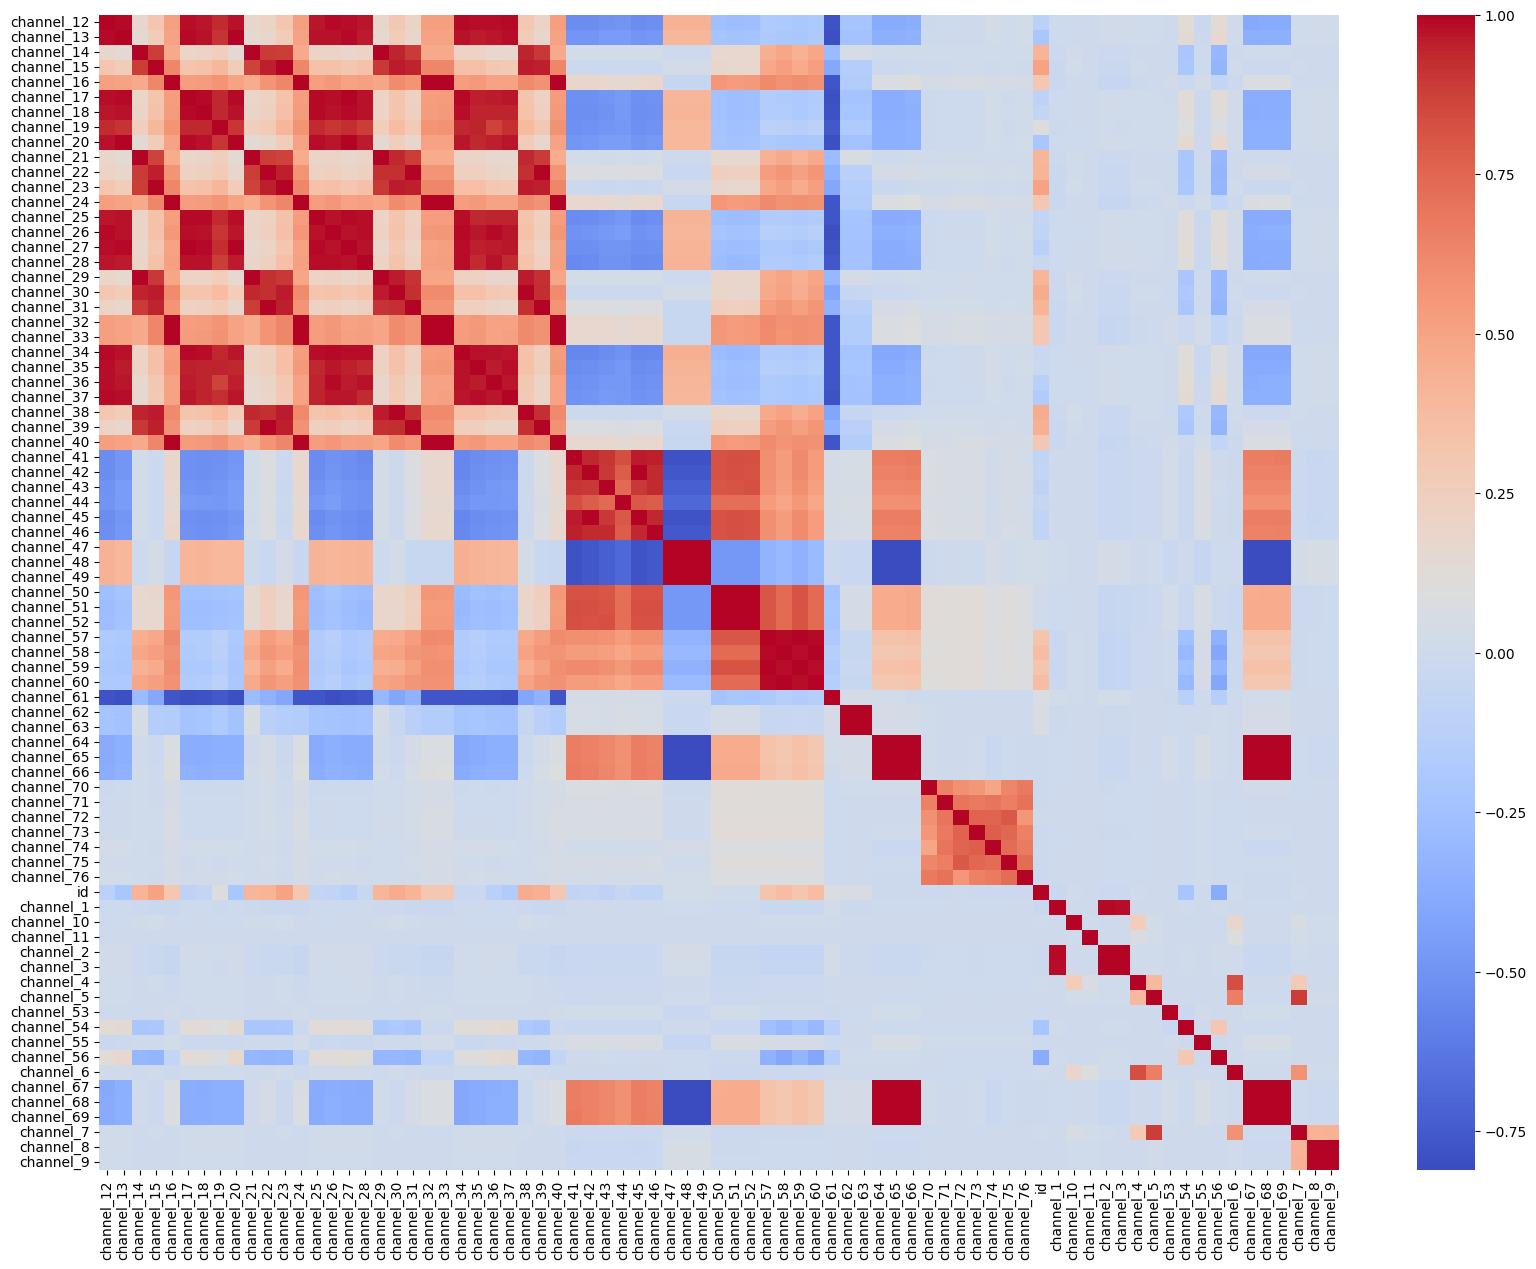

In [6]:
random_indices = np.random.choice(X_train.shape[0], size=1500000, replace=False)

corr = X_train.iloc[random_indices].corr()

plt.figure(figsize=(20, 15))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

Next correlation between telecommands feature is studied. From the correlation matrix it can be saw that no significant correlation exists amongst those features.

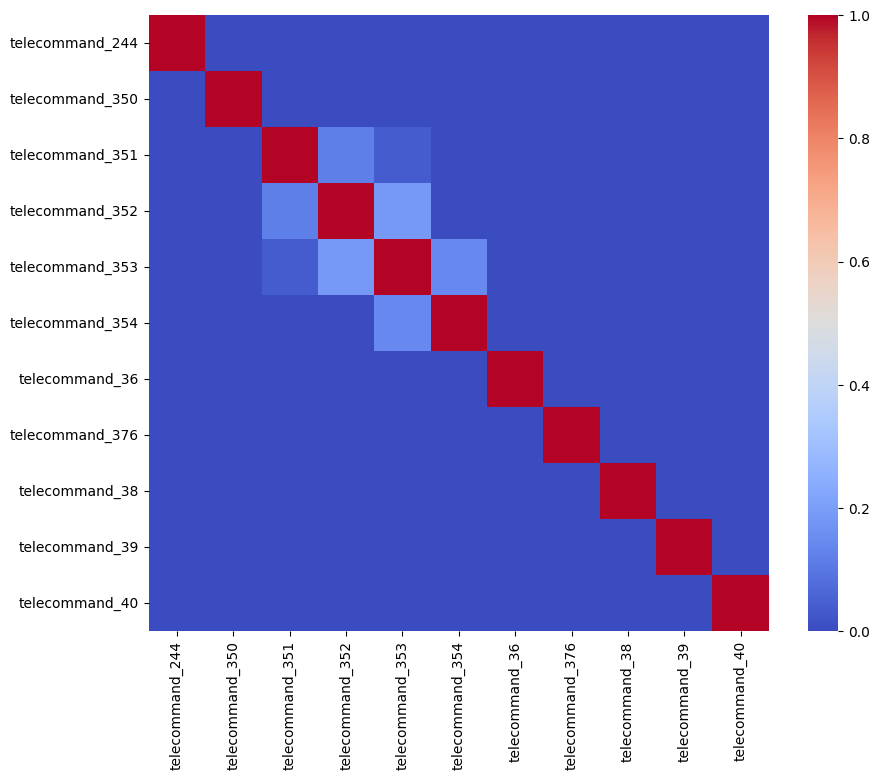

In [7]:
corr = train_df[telecommands_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

As suggested by the authors of the competition the set of target channel 41-46 can be used as a starting point to do model evaluations. This feature are combined with the telecommands feature and the non target channels

In [8]:
def extract_telemetry_index(telemetry_channels,channels):
    return {col: channels.index(col) for col in telemetry_channels}

telemetry_channels = ['channel_41','channel_42','channel_43','channel_44','channel_45','channel_46']
channel_to_use = telemetry_channels + telecommands_columns + non_target_columns

index_map = extract_telemetry_index(telemetry_channels,channel_to_use)
index_map

{'channel_41': 0,
 'channel_42': 1,
 'channel_43': 2,
 'channel_44': 3,
 'channel_45': 4,
 'channel_46': 5}

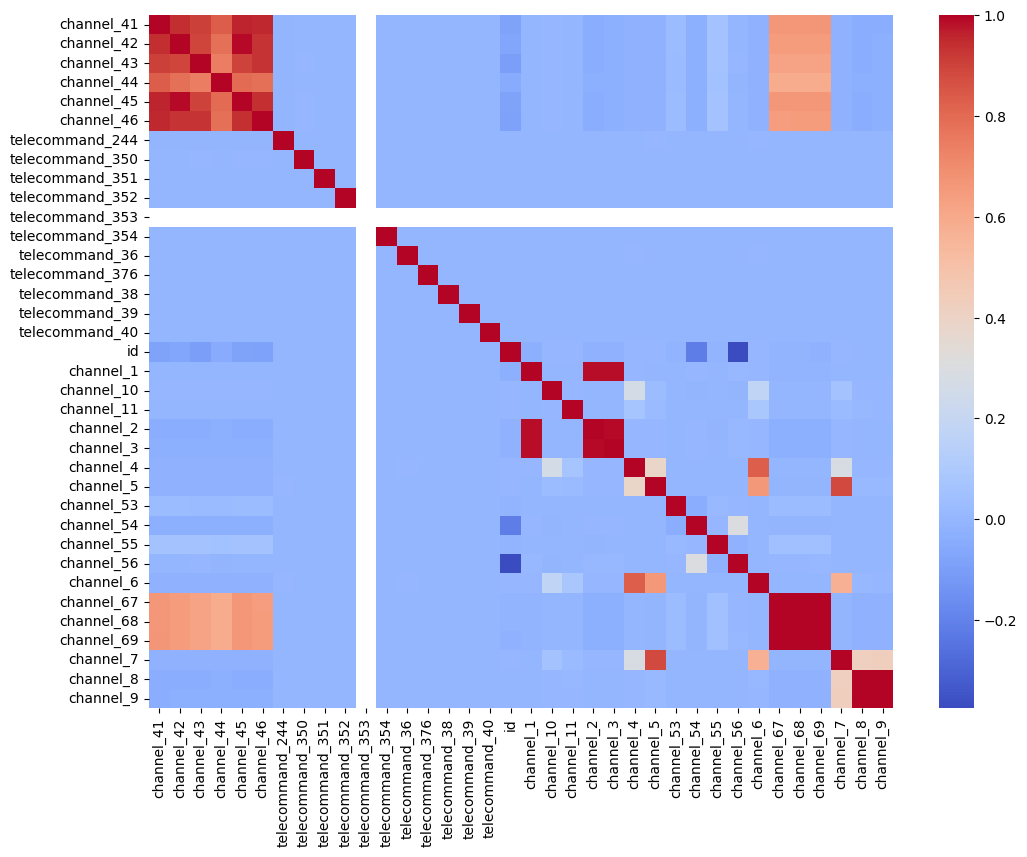

In [9]:
corr = train_df.iloc[random_indices][channel_to_use].corr()

plt.figure(figsize=(12, 9))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.show()

To capture the time dependency of the registered feeature a common approach used by the vast majority of models that works on time series data is to subdivide the time series into time windows of a fixed size. A subdivision of the time series is done accordingly to this also to batch the observation.\
At this early stage the subdivision is done on a smaller set of data.


In [10]:
channel_to_use = channel_to_use + ['is_anomaly']
portion_data = train_df[0:500000][channel_to_use] 

X = portion_data.drop(columns=['is_anomaly','id'])
y = portion_data['is_anomaly']
y.value_counts()

is_anomaly
0    413755
1     86245
Name: count, dtype: int64

Then the subdivision is done by using a windows of size 10.

In [11]:
X.shape

(500000, 35)

In [12]:
def split_window(X,y,window_size=10,step=1):
    X_splitted, y_splitted = [],[]
    for i in range(0,len(X)-window_size,step):
        X_splitted.append(X[i:i+window_size])
        y_splitted.append(y[i:i+window_size])
        
    X_splitted = np.array(X_splitted)
    y_splitted = np.array(y_splitted)
    return X_splitted, y_splitted

X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.25)

X_windowed,y_windowed = split_window(X_train,y_train,window_size=25)

In [13]:
X_train.columns

Index(['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45',
       'channel_46', 'telecommand_244', 'telecommand_350', 'telecommand_351',
       'telecommand_352', 'telecommand_353', 'telecommand_354',
       'telecommand_36', 'telecommand_376', 'telecommand_38', 'telecommand_39',
       'telecommand_40', 'channel_1', 'channel_10', 'channel_11', 'channel_2',
       'channel_3', 'channel_4', 'channel_5', 'channel_53', 'channel_54',
       'channel_55', 'channel_56', 'channel_6', 'channel_67', 'channel_68',
       'channel_69', 'channel_7', 'channel_8', 'channel_9'],
      dtype='object')

# First model training
As a starting point it can be usefull to try to train a simpler model on the data and check if it learn how to detect anomalies.\
To do so a simple linear regression model is used.

In [14]:
lr_model = nn.Sequential(nn.Linear(X_windowed.shape[2],1),nn.Sigmoid())

It is trained on the datas extracted above.

100%|██████████| 374975/374975 [02:29<00:00, 2506.77it/s]


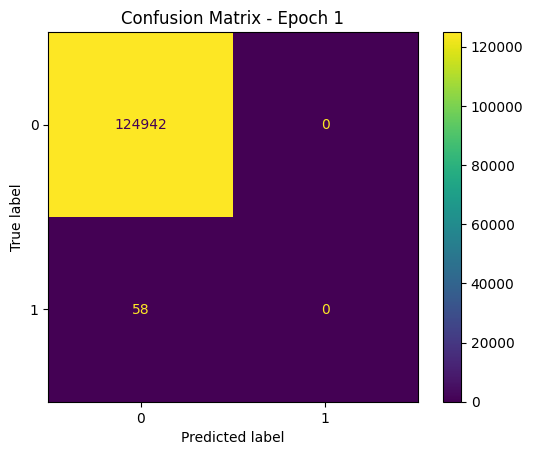

In [15]:
def train_model(X_train,y_train, X_eval, y_eval, model, epochs=1):
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()

    X_eval = torch.tensor(X_eval.to_numpy()).float()
    y_eval = torch.tensor(y_eval.to_numpy()).float()

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(epochs):
        model.train()
        for i in tqdm(range(len(X_train))):
            optimizer.zero_grad()

            y_prob = model(X_train[i])
            
            loss = criterion(y_prob,y_train[i].unsqueeze(1))
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            prob = model(X_eval)
            y_pred = (prob >=0.5).int()
            cm = confusion_matrix(y_eval,y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
            disp.plot()
            plt.title(f"Confusion Matrix - Epoch {epoch+1}")
            plt.show()
        

train_model(X_windowed,y_windowed,X_test,y_test,lr_model)    

As it can be saw the linear model does not detect anomalies at all.\ This model can be still usefull to estimate the feature importance of the training data.

In [16]:
def pair_feature_importance(feature_importance,columns):
    pair_map = {}
    for c,i in zip(columns,feature_importance):
        pair_map[c] = i
    return pair_map

weights = lr_model[0].weight.data
feature_importance = torch.abs(weights).squeeze().tolist()
columns = X_train.columns.to_list()
paired_fi = pair_feature_importance(feature_importance,columns)

As it can be saw the feature importance vary a lot from feature to feature, with low value that are even below 0.01.\
To reduce dimensionality of the data used for the training process it can be usefull to drop colummns with low feature importance.

In [17]:
def drop_low_fi_features(feature_importance,threshold=1e-2):
    features_to_drop = []
    for c in feature_importance.keys():
        if feature_importance[c] <= threshold:
            features_to_drop.append(c)
    return features_to_drop

to_drop = drop_low_fi_features(paired_fi)

X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)
X_train.columns

Index(['channel_41', 'channel_42', 'channel_43', 'channel_44', 'channel_45',
       'channel_46', 'telecommand_244', 'telecommand_350', 'telecommand_351',
       'telecommand_352', 'telecommand_353', 'telecommand_354',
       'telecommand_36', 'telecommand_376', 'telecommand_38', 'telecommand_39',
       'telecommand_40', 'channel_1', 'channel_10', 'channel_11', 'channel_2',
       'channel_3', 'channel_4', 'channel_5', 'channel_53', 'channel_54',
       'channel_55', 'channel_56', 'channel_6', 'channel_67', 'channel_68',
       'channel_69', 'channel_7', 'channel_8', 'channel_9'],
      dtype='object')

Done this it's necessary to pass on a more advanced neural network architecture witch uses more information from the original time series to do the predictions. \
This can be done by using a LSTM.
To use an LSTM the train data are divided in windows, but this time it's considered also the last element to predict.

In [18]:
def split_window_lstm(X,y,lookback=10,step=1):
    X_splitted, y_splitted = [],[]
    for i in range(0,len(X)-lookback,step):
        X_splitted.append(X[i:i+lookback])
        y_splitted.append(y[i+1:i+lookback+1])
        
    X_splitted = np.array(X_splitted)
    y_splitted = np.array(y_splitted)
    return X_splitted, y_splitted

X_windowed,y_windowed = split_window_lstm(X_train,y_train,lookback=50,step=50)

In [19]:
X_windowed.shape

(7499, 50, 35)

The first lstm model is a simple 1 layer lstm.

In [20]:
class Simple_LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers):
        super().__init__()
        self.lstm = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size,1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out) 
        out = torch.sigmoid(out)
        return out

model = Simple_LSTM(input_size=X_windowed.shape[2],hidden_size=64,num_layers=1)    

Next step is to define a training loop for the model.

In [21]:
def train_lstm_model(X_train,y_train,X_eval,y_eval,model,n_epochs=5):
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).float()

    X_eval = torch.tensor(X_eval.to_numpy()).float()
    y_eval = torch.tensor(y_eval.to_numpy()).float()

    optimizer = Adam(model.parameters(),lr=1e-1)
    loss_fn = nn.BCELoss()
    loader = DataLoader(TensorDataset(X_train, y_train), shuffle=True, batch_size=10)
    for epoch in range(n_epochs):
        model.train()
        for X_batch, y_batch in loader:
            y_pred = model(X_batch).squeeze(-1)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            y_pred = model(X_eval).squeeze(-1)
            loss = loss_fn(y_pred, y_eval)
        print(f"Epoch {epoch}: BCE {loss:.4f}")

train_lstm_model(X_windowed,y_windowed,X_test,y_test,model)

Epoch 0: BCE 0.3112
Epoch 1: BCE 0.3291
Epoch 2: BCE 0.0776
Epoch 3: BCE 0.1261
Epoch 4: BCE 0.4696


The model don't learn how to detect anomalies well and this is reflected by the low variation into the BCE registered into the model test at each epoch. 

This can be caused by the combination of two different elements:
* too simple network
* not so good threshold for anomaly detection.

To avoid this a more sofisticated network and the dynamic error threshold described first by Hundman et al. (2018) are used for processing the data and detecting the anomalies.

# Model used
The final nn model used consist into a mixture of LSTM that predicts each one of the telemetric channels present into the original dataset.\
The prediction obtained are later used to detect the anomaly time step from the normal ones.

In [22]:
model = AdvancedLSTM(X_windowed.shape[2]-1,64,1,telemetry_channels,index_map)
print(model)

AdvancedLSTM(
  (networks): ModuleDict(
    (channel_41): ModuleDict(
      (lstm): LSTM(34, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (channel_42): ModuleDict(
      (lstm): LSTM(34, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (channel_43): ModuleDict(
      (lstm): LSTM(34, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (channel_44): ModuleDict(
      (lstm): LSTM(34, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (channel_45): ModuleDict(
      (lstm): LSTM(34, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=1, bias=True)
    )
    (channel_46): ModuleDict(
      (lstm): LSTM(34, 64, batch_first=True)
      (fc): Linear(in_features=64, out_features=1, bias=True)
    )
  )
)


Given the model implementation the next step is to define a training approach into a well defined procedure.

In [23]:
def train_advanced_model(X_train,X_eval,telemetry_columns,model,num_epocs=1):
    X_train = torch.tensor(X_train).float()

    X_eval = torch.tensor(X_eval.to_numpy()).float().unsqueeze(0) 

    optimizer = Adam(model.parameters(),lr=1e-3)
    loss_fn = nn.MSELoss()
    loader = DataLoader(TensorDataset(X_train), shuffle=True, batch_size=10)

    for epoch in tqdm(range(num_epocs)):
        model.train()
        for (X_batch,) in loader:
            y_pred, y_true = model(X_batch)
            
            loss = 0
            for i,c in enumerate(telemetry_columns):
                loss += loss_fn(y_pred[i], y_true[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred,y_true = model(X_eval)
            loss = 0
            for i,c in enumerate(telemetry_columns):
                loss += loss_fn(y_pred[i], y_true[i])
                    
        print(f"Epoch {epoch}: MSE {loss:.4f}")



To avoid data leakage te testing data si taken from another section of the original dataset.

In [24]:
test_data = train_df[600000:850000][channel_to_use] 

c_d = to_drop + ['is_anomaly','id']
X_eval = test_data.drop(columns=c_d)
y_eval = test_data['is_anomaly']

In [25]:
train_advanced_model(X_windowed,X_test,telemetry_channels,model)

100%|██████████| 1/1 [00:19<00:00, 19.59s/it]

Epoch 0: MSE 0.0017


In [26]:
torch.save(model, "model.pth")

In [27]:
type(X_train)

pandas.core.frame.DataFrame

# Anomaly detection
Given the nn model that predicts the telemetry feature it's possible to create an anomaly detection algorithm which uses those prediction accordingly to Hundman et al. (2018).\
The approach used for detecting anomalies uses the error the exist amonghst the telemetry predicted value and the true value and use those to calculate a dynamic threshold witch split the data in anomaly points and normal points.\
To realize this method in the first step the dynamic thresholds are calculated using the training data to obtain the errors on each estimated telemetry channel.

In [28]:
detector = AnomalyDetector(model)

In [29]:
time_series = torch.tensor(X_train.to_numpy()).float().unsqueeze(0) 
torch.save(time_series, "train_data.pt")
errors = detector.calculate_errors(time_series)
detector.emwa(errors)

In [30]:
errors

{'channel_41': tensor([[0.0111, 0.0079, 0.0008,  ..., 0.0276, 0.0255, 0.0104]],
        grad_fn=<AbsBackward0>),
 'channel_42': tensor([[0.0584, 0.0265, 0.0007,  ..., 0.0053, 0.0006, 0.0122]],
        grad_fn=<AbsBackward0>),
 'channel_43': tensor([[0.0300, 0.0326, 0.0208,  ..., 0.0199, 0.0169, 0.0067]],
        grad_fn=<AbsBackward0>),
 'channel_44': tensor([[0.1015, 0.0085, 0.0305,  ..., 0.0011, 0.0087, 0.0271]],
        grad_fn=<AbsBackward0>),
 'channel_45': tensor([[0.0368, 0.0069, 0.0102,  ..., 0.0069, 0.0018, 0.0120]],
        grad_fn=<AbsBackward0>),
 'channel_46': tensor([[0.0220, 0.0093, 0.0056,  ..., 0.0159, 0.0070, 0.0046]],
        grad_fn=<AbsBackward0>)}

In [31]:
detector.estimate_scores(errors)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html